# Auto-mpg 데이터를 활용한 Regression 문제

아래 파이썬 코드는 UC Irvine Machine Learning repository에 저장되어 있는 auto-mpg 데이터를 불러와 8가지 모델과 Azure Machine Learning Service의 Automated Machine Learning 방법을 활용해 나온 최적의 모델을 비교합니다. 

아래 코드에서 활용된 8가지 모델은 다음과 같습니다.
   1. Linear Regression
   2. Lasso Regression
   3. Ridge Regression
   4. Random Forest
   5. Decision Tree
   6. ElasticNet
   7. Gradient Boosting
   8. XG Boost


## Azure ML 설정 (Configuration)

아래 코드는 ML workspace 연동과 computing resource 지정 등을 수행합니다.

In [ ]:
import sys
import warnings
import azureml.core
import os
from azureml.core import Workspace
from azureml.core import Experiment
from azureml.core.compute import AmlCompute, ComputeTarget

warnings.simplefilter("ignore")

subscription_id = '94ff7c1e-50c0-4466-a33b-232a0ccff39d'
resource_group = 'ml-service-demos'
workspace_name = 'Demo-Roy'
workspace_region = 'eastus'

ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)

ws.write_config()

experiment_name = 'sklearn-mpg'
exp = Experiment(workspace = ws, name = experiment_name)

compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "CPUcluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")

if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('Found a compute target!', compute_name, 'has been attached.')
else:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size, 
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)
    print('Created a compute target!', compute_name, 'has been attached.')

## 데이터셋 불러오기

머신러닝을 시작하기 전 필요한 단계를 완료했으면 분석에 필요한 데이터를 불러오겠습니다. 이 예제에서 활용하는 데이터는 UC Irvine 대학의 머신러닝 데이터베이스에 저장되어 있는 데이터로 차량의 연비와 다양한 정보를 포함하고 있는 데이터셋입니다. 우선 데이터를 불러오기 위해선 데이터셋이 저장되어 있는 url주소를 dataset_root로 저장합니다. 그리고 pandas의 read_csv를 사용합니다. 현재 url에 저장되어 있는 데이터셋은 헤더를 포함하고 있지 않으므로 필드별로 맞는 이름을 지정해줍니다. 그리고 처음 5개 행을 display할 경우 다음과 같은 결과가 나옵니다.

In [ ]:
import pandas as pd
import numpy as np
dataset_root = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"

data = pd.read_csv(dataset_root, delim_whitespace = True, header=None,
                   names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model', 'origin', 'car_name'])

display(data.head(5))

## 데이터셋 확인하기

불러온 데이터셋의 크기를 확인하기 위해 shape 사용할 경우 다음과 같이 398개의 행과 9개의 열로 구성되어 있는 것을 확인할 수 있습니다. 이를 통해 현재 불러온 데이터셋은 9개 종류와, 398개의 데이터 수가 있는 것을 확인 할 수 있습니다.

In [ ]:
data.shape

머신러닝 모델을 만들기 전, 불러온 데이터셋에 비정상적인 데이터가 없는지 확인하기 위해 dataframe에 describe를 적용하면 간단한 통계를 확인할 수 있습니다. 

In [ ]:
data.describe()

위와 같이 describe를 사용할 경우 여러 필드 중 horsepower와 car_name이 빠져있는 것을 확인할 수 있습니다. 왜 빠져있는지 확인하기 위해 dtypes 사용할 경우 각 필드 값이 저장되어 있는 데이터의 포맷을 확인할 수 있습니다.

In [ ]:
data.dtypes

데이터셋 불러오기에서 확인한 5개의 샘플을 보면 horsepower가 float 포맷으로 예상되었지만 현재 object으로 저장되어 있음을 확인할 수 있습니다. 정확하게 어떤 데이터들이 포함되어 있는지 확인하기 위해 horsepower의 unique한 값을 불러옵니다.

In [ ]:
data.horsepower.unique()

## 데이터 전처리

unique한 horsepower의 값을 불러올 경우 여러 숫자들 중 193.0과 100.0 사이 물음표가 포함되어 있다는 점을 확인할 수 있습니다. 이처럼 실제 데이터는 결측치, 이상치 등 다양한 값들이 포함되어 있어 머신러닝 모델을 적용하기 전 전처리 과정이 필요합니다. 이번 예제의 경우 물음표가 포함된 데이터 행을 모두 삭제하도록 하겠습니다. 

In [ ]:
data=data[data.horsepower != '?']

물음표를 삭제한 이후 나머지 데이터들은 모두 숫자로 이루어져있기 때문에 horsepower의 데이터 타입을 astype 메소드를 활용해 float로 변환해줍니다.

In [ ]:
data.horsepower = data.horsepower.astype(float) 

데이터 타입 변환 이후 dtypes를 활용하여 다시 모든 필드의 데이터 타입을 확인할 경우 예상한 타입들이 잘 들어가 있는 것으로 확인되었습니다.

In [ ]:
data.dtypes

그리고 다시 shape을 이용하여 데이터셋의 크기를 확인할 경우 행이 392개로 변경된 것을 확인할 수 있습니다. 이는 horsepower의 값이 물음표인 6개 행을 삭제하였기 때문입니다.

In [ ]:
data.shape

모든 데이터셋이 결측치 및 이상치가 없는지 확인을 한 이후 머신러닝 모델을 만들기 위해 예측에 활용될 변수(X)와 실제값(Y)을 지정하고 80:20 비율로 학습용 데이터셋과 검증용 데이터셋을 분리하였습니다. 이 예제의 경우 데이터 셋을 나눌 때 무작위로 데이터셋이 추출 될 수 있도록 random seed를 123으로 설정하였습니다. display를 활용하여 학습용 데이터셋의 X와 Y를 확인할 경우 랜덤한 순서로 5가지의 X변수와 1개의 Y변수가 잘 생성된 것을 확인할 수 있습니다.

In [ ]:
from sklearn.model_selection import train_test_split

x_name = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']
y_name = ['mpg']

x = data[x_name]
y = data[y_name]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=123)

display(train_x.head(5))
display(train_y.head(5))

## 머신러닝 모델 사용하기

이번 예제에서는 여러 모델의 성능 비교를 위해 Scikit-learn 라이브러리를 사용합니다. XG Boost의 경우 Scikit-learn에서 지원되지 않으므로 별도로 XG boost 패키지를 다운 받아야 합니다.

### Linear Regression

In [ ]:
from sklearn import linear_model
lr = linear_model.LinearRegression(normalize=True).fit(train_x, train_y)
lr_y = lr.predict(test_x)
result = pd.concat([test_y.reset_index(drop=True), pd.DataFrame(lr_y, columns=["mpg_lr"])], axis=1)

### Lasso Regression

In [ ]:
from sklearn import linear_model
lar = linear_model.Lasso(alpha=0.001, normalize=True, random_state=123).fit(train_x, train_y)
lar_y = lar.predict(test_x)
result = pd.concat([result, pd.DataFrame(lar_y, columns=["mpg_lar"])], axis=1)

### Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
rr = linear_model.Ridge(alpha=100, normalize=True, max_iter=5000, random_state=123).fit(train_x, train_y)
rr_y = rr.predict(test_x)
result = pd.concat([result, pd.DataFrame(rr_y, columns=["mpg_rr"])], axis=1)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=20, random_state=123).fit(train_x, train_y)
rf_y = rf.predict(test_x)
result = pd.concat([result, pd.DataFrame(rf_y, columns=["mpg_rf"])], axis=1)

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=123).fit(train_x, train_y)
dt_y = dt.predict(test_x)
result = pd.concat([result, pd.DataFrame(dt_y, columns=["mpg_dt"])], axis=1)

### ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNet
en = ElasticNet(random_state=123).fit(train_x, train_y)
en_y = en.predict(test_x)
result = pd.concat([result, pd.DataFrame(en_y, columns=["mpg_en"])], axis=1)

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=500, 
                               max_depth=4, 
                               min_samples_split=2, 
                               learning_rate=0.01,
                               loss='ls', 
                               random_state=123).fit(train_x, train_y)
gb_y = gb.predict(test_x)
result = pd.concat([result, pd.DataFrame(gb_y, columns=["mpg_gb"])], axis=1)

### XG Boost

Jupyter notebook에서는 아래와 같이 '!pip' 명령어를 사용하면 XG Boost 패키지를 쉽게 설치할 수 있습니다.

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb
xb = xgb.XGBRegressor(objective ='reg:linear', 
                      colsample_bytree = 0.6, 
                      learning_rate = 0.01, 
                      max_depth = 5, 
                      alpha = 10, 
                      n_estimators =800, 
                      seed=123).fit(train_x, train_y)
xb_y = xb.predict(test_x)
result = pd.concat([result, pd.DataFrame(xb_y, columns=["mpg_xb"])], axis=1)

## Automated ML 사용하기

Automated ML이란 Azure Machine Learning Service에서 지원하는 기능으로 config값을 지정해주고 실행할 경우 여러가지 모델에 hyperparameter 값을 최적화한 best model을 찾아줍니다. Automated ML에 사용되는 모델은 다음과 같습니다.

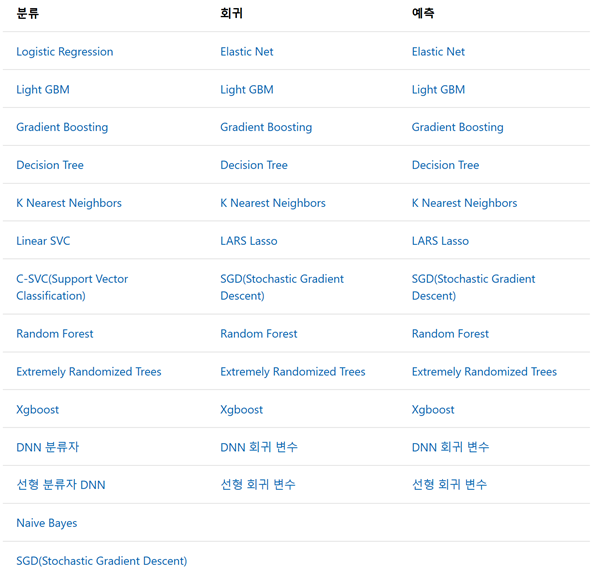

In [ ]:
import logging

automl_settings = {
    "iteration_timeout_minutes" : 10,
    "iterations" : 30,
    "primary_metric" : 'normalized_mean_absolute_error',
    "preprocess" : True,
    "verbosity" : logging.INFO,
    "n_cross_validations": 5
}

In [ ]:
from azureml.train.automl import AutoMLConfig

# project folder
project_folder = './automated-ml-regression'

# local compute
automated_ml_config = AutoMLConfig(task = 'regression',
                                   debug_log = 'automated_ml_errors.log',
                                   path = project_folder,
                                   X = train_x.values,
                                   y = train_y.values.flatten(),
                                   **automl_settings)

위에서 실행한 AutoMLConfig 값으로 experiment를 submit할 경우 automated machine learning 기능이 수행됩니다.

In [ ]:
from azureml.core.experiment import Experiment
experiment=Experiment(ws, experiment_name)
run = experiment.submit(automated_ml_config, show_output=True)

Automated ML의 결과 값을 get_output으로 실행할 경우 최적의 모델에 대한 정보를 확인할 수 있습니다.

In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()

In [ ]:
run.wait_for_completion(show_output=False)

In [ ]:
best_run, fitted_model = run.get_output()
print(best_run)
print(fitted_model)

다른 모델처럼 best model의 predict를 사용할 경우 test data에 대한 예측값을 계산하게 됩니다.

In [ ]:
bm_y = fitted_model.predict(test_x.values)
result = pd.concat([result, pd.DataFrame(bm_y, columns=["mpg_bm"])], axis=1)
result

이번 예제에서는 회귀문제에서 사용되는 metric 중 하나인 MAPE(Mean Absolute Percentage Error)를 사용하도록 하겠습니다. MAPE의 경우 별도의 라이브러리나 패키지가 없으므로 사용자 정의 함수를 사용하여 만들어 보겠습니다.

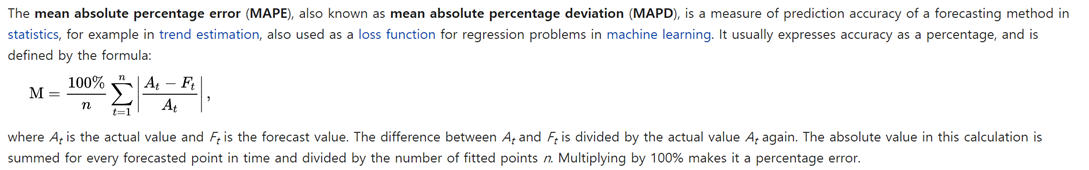

In [ ]:
import numpy as np

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

마지막으로 Automated ML에서 확인한 best model을 포함한 여러 모델의 MAPE와 RMSE(Root Mean Square Error)를 비교해보도록 하겠습니다. 

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mape_comp = []
rmse_comp = []

al_name=["lr_y", "lar_y", "rr_y", "rf_y", "dt_y", "en_y", "gb_y", "xb_y", "bm_y"]
row_name=["Linear Regression", "Lasso Regression", "Ridge Regression", "Random Forest", 
          "Decision Tree", "Elastic Network", "Grdient Boosting", "XG Boost", "Best Model"]

act_y = list(test_y['mpg'])

for pred_y in al_name:
    mape_comp.append(mape(act_y, eval(pred_y)))
    rmse_comp.append(sqrt(mean_squared_error(act_y, eval(pred_y))))

pd.set_option('float_format', '{:f}'.format)
res=pd.concat([pd.DataFrame(mape_comp, index=row_name, columns=["MAPE"]), 
               pd.DataFrame(rmse_comp, index=row_name, columns=["RMSE"])], axis=1)
res

MAPE를 비교할 경우 Best Model이 다른 모델보다 낮고 RMSE 또한 낮은 것으로 확인되었습니다. 위 결과를 보게 되면 흥미로운 점이 있습니다. 대부분 모델들이 MAPE가 낮을 경우 RMSE 또한 낮습니다. 하지만 종종 아닌 경우도 발생합니다. 예를 들어 Decision Tree의 경우 MAPE가 Linear Regression보다 훨씬 낮았지만 RMSE는 오히려 높았습니다. 이처럼 머신러닝에서는 어떤 metric을 사용하는지에 따라 가장 성능이 좋은 모델이 다를 수 있고 어떠한 모델도 무조건 우월하지 않습니다.